In [1]:
from typing import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
from matplotlib.ticker import FuncFormatter

/tmp/ipykernel_3362012/519942491.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(total)


<BarContainer object of 20 artists>


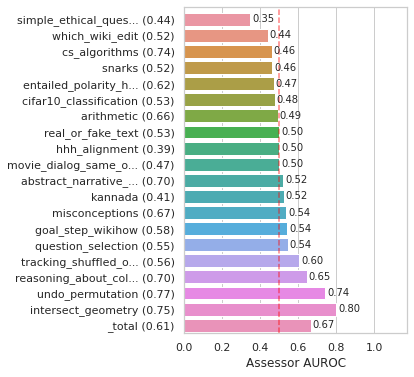

In [2]:
df = pd.read_csv('../artifacts/csv-results/task-generalisation/results-base.csv')
df = df.rename(columns={df.columns[0]: 'task'})
df = df.sort_values(by='task')
df = df.reset_index(drop=True)

ref = pd.read_csv('../artifacts/csv-results/scaling-0sh/128b.csv')
ref = ref.rename(columns={ref.columns[0]: 'task'})
ref = ref.loc[ref['task'].isin(df['task'])]
ref = ref.sort_values(by='task')
ref = ref.reset_index(drop=True)

assert all(df.task == ref.task)

# Copy values from ref for baselines (starting with test_conf_)
cols = [col for col in ref.columns if str(col).startswith('test_conf_')]
df[cols] = ref[cols]
del ref

Baseline = Literal['normalized', 'absolute', 'distribution']

def shorten(x, length=15):
    if len(x) > length:
        return x[:length-3] + "..."
    else:
        return x

def plot(df: pd.DataFrame, baseline: Baseline = "normalized", metric: str = "roc_auc"):
    sns.set_theme(style="whitegrid")
    task_system_col = f"test_conf_{baseline}_{metric}"
    assessor_col = f"test_{metric}"

    data = df[[task_system_col, assessor_col, 'task', 'count']]

    data = data[df['test_conf_normalized_roc_auc'] > 0.1]
    data = data[data['count'] > 100]
    data['diff'] = data[assessor_col] - data[task_system_col]
    data['task'] = data['task'].apply(lambda x: shorten(x, length=22))

    # Sorting and adding total
    data.sort_values(by=assessor_col, inplace=True)
    # data.sort_values(by='diff', inplace=True)
    total = data[data['task'] == '_total']
    data = data[data['task'] != '_total']
    data = data.append(total)

    plt.figure(figsize=(4,6))
    # plt.rcParams.update({'font.size': 12})
    
    y = data.apply(lambda x: f"{x['task']} ({x[task_system_col]:.2f})", axis=1)
    # y = data.apply(lambda x: f"{x['task']}", axis=1)
    # p = sns.barplot(y=y, x="diff", data=data, orient='h')
    p = sns.barplot(y=y, x=assessor_col, data=data, orient='h')
    # sns.barplot(y=y, x=task_system_col, data=data, orient='h', color='grey')
    p.axvline(0.5, color='red', linestyle='--', alpha=0.5)

    for i in p.containers:
        print(i)
        p.bar_label(i,fmt='%.2f', label_type='edge', padding=2)
    p.set_xlim(p.get_xlim()[0]*1.6, p.get_xlim()[1]*1.4)
    p.set_ylim(p.get_ylim()[0]*1.0, p.get_ylim()[1]*1.5)

    p.set_xlabel("Assessor AUROC")
    plt.savefig(f'../artifacts/plots/task-generalisation.svg', bbox_inches='tight', format='svg')
    # return data

# plot(results, metric="accuracy")
plot(df, metric="roc_auc")

<BarContainer object of 19 artists>


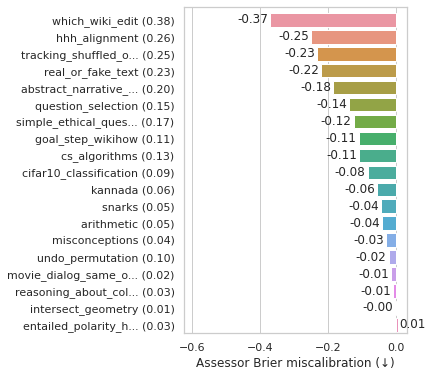

In [3]:
def plot_diff(df: pd.DataFrame, baseline: Baseline = "normalized", metric: str = "roc_auc"):
    sns.set_theme(style="whitegrid")
    task_system_col = f"test_conf_{baseline}_{metric}"
    assessor_col = f"test_{metric}"

    data = df[[task_system_col, assessor_col, 'task', 'count']]

    data = data[df['test_conf_normalized_roc_auc'] > 0.1]
    data = data[data['count'] > 100]
    data['diff'] = data[assessor_col] - data[task_system_col]
    data['task'] = data['task'].apply(lambda x: shorten(x, length=22))

    # Sorting and adding total
    data.sort_values(by=assessor_col, inplace=True)
    data.sort_values(by='diff', inplace=True)
    total = data[data['task'] == '_total']
    data = data[data['task'] != '_total']

    plt.figure(figsize=(4,6))
    # plt.rcParams.update({'font.size': 12})
    
    y = data.apply(lambda x: f"{x['task']} ({x[task_system_col]:.2f})", axis=1)
    # y = data.apply(lambda x: f"{x['task']}", axis=1)
    p = sns.barplot(y=y, x="diff", data=data, orient='h')
    # p = sns.barplot(y=y, x=assessor_col, data=data, orient='h')
    # sns.barplot(y=y, x=task_system_col, data=data, orient='h', color='grey')
    # p.axvline(0.5, color='red', linestyle='--', alpha=0.5)

    for container in p.containers:
        print(container)
        labels = [f"{x:.2f}" for x in data['diff'].values]
        p.bar_label(container, labels=labels, label_type='edge', padding=2)
    p.set_xlim(p.get_xlim()[0]*1.6, p.get_xlim()[1]*1.4)
    p.set_ylim(p.get_ylim()[0]*1.0, p.get_ylim()[1]*1.5)

    p.set_xlabel("Assessor Brier miscalibration (↓)")
    plt.savefig(f'../artifacts/plots/task-generalisation-bs_mcb.svg', bbox_inches='tight', format='svg')
    # return data

# plot(results, metric="accuracy")
plot_diff(df, metric="bs_mcb")
# plot_diff(df, metric="bs")

In [5]:
from lass.log_handling import LogLoader, LogLoaderArgs
import lass.datasets
import lass.pipeline

filtered = df[df['test_conf_normalized_roc_auc'] > 0.1]
filtered = filtered[filtered['count'] > 100]
log_loader_args = LogLoaderArgs(
    logdir='../artifacts/logs/',
    tasks=filtered.task.unique().tolist(),
    model_families=['BIG-G T=0'],
    model_sizes=['128b'],
    shots=[0],
    query_types=['multiple_choice'],
)
log_loader = LogLoader(log_loader_args)
perf = lass.datasets.to_dataframe(log_loader)
perf = lass.pipeline.binarize(perf)
perf = lass.pipeline.augment(perf)
perf = lass.pipeline.clean(perf)

/home/wout/pp/lass/src/lass/pipeline.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'correct'] = df['correct'].astype(int)


In [6]:
perf['rand_correct'] = 1 / perf['n_targets']
g = perf.groupby(['task']).agg(
    acc=('correct', 'mean'),
    rand_correct=('rand_correct', 'mean'),
)
acc_diff = (g['acc'] - g['rand_correct'])
acc_diff = acc_diff.append(pd.Series((perf.correct.mean() - perf.rand_correct.mean()), index=['_total']))
acc_diff = acc_diff.to_frame("acc_diff")
acc_diff.reset_index(inplace=True)
acc_diff = acc_diff.rename(columns = {'index':'task'})

acc_diff

/tmp/ipykernel_3362012/2498134174.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_diff = acc_diff.append(pd.Series((perf.correct.mean() - perf.rand_correct.mean()), index=['_total']))


,task,acc_diff
0,abstract_narrative_understanding,0.230000
1,arithmetic,0.032100
2,cifar10_classification,0.001562
3,cs_algorithms,-0.049279
4,entailed_polarity_hindi,0.144928
5,goal_step_wikihow,0.040127
6,hhh_alignment,-0.065611
7,intersect_geometry,0.095218
8,kannada,-0.022679
9,misconceptions,0.015982


/tmp/ipykernel_3362012/4190190040.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(total)


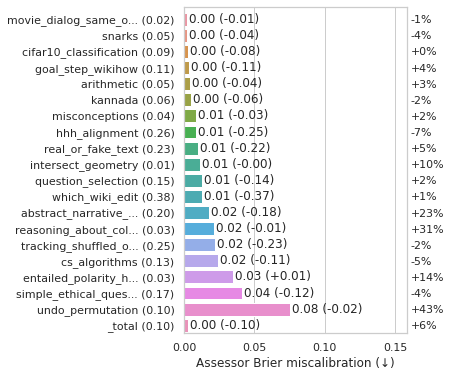

In [8]:
def plot_bs(df: pd.DataFrame, baseline: Baseline = "normalized", metric: str = "roc_auc", acc_diff = None):
    sns.set_theme(style="whitegrid")
    task_system_col = f"test_conf_{baseline}_{metric}"
    assessor_col = f"test_{metric}"

    data = df[[task_system_col, assessor_col, 'task', 'count']]

    data = data[df['test_conf_normalized_roc_auc'] > 0.1]
    data = data[data['count'] > 100]
    data['diff'] = data[assessor_col] - data[task_system_col]
    # data['task'] = data['task'].apply(lambda x: shorten(x, length=22))

    # Sorting and adding total
    data.sort_values(by=assessor_col, inplace=True)
    # data.sort_values(by='diff', inplace=True)
    total = data[data['task'] == '_total']
    data = data[data['task'] != '_total']
    data = data.append(total)

    fig = plt.figure(figsize=(4,6)) 
    ax1 = fig.add_subplot(111)
    # plt.rcParams.update({'font.size': 12})
    
    y = data.apply(lambda x: f"{shorten(x['task'], length=22)} ({x[task_system_col]:.2f})", axis=1)
    # y = data.apply(lambda x: f"{x['task']}", axis=1)
    # p = sns.barplot(y=y, x="diff", data=data, orient='h')
    p = sns.barplot(y=y, x=assessor_col, data=data, orient='h')
    # sns.barplot(y=y, x=task_system_col, data=data, orient='h', color='grey')
    # p.axvline(0.5, color='red', linestyle='--', alpha=0.5)

    for i in p.containers:
        # labels = [f"{m:.2f}" for diff, m in zip(data['diff'].values, data[assessor_col].values)]
        labels = [f"{m:.2f} ({diff:+.2f})" for diff, m in zip(data['diff'].values, data[assessor_col].values)]
        p.bar_label(i, labels=labels, label_type='edge', padding=2)
        # p.bar_label(i,fmt='%.2f', label_type='edge', padding=2)
    p.set_xlim(p.get_xlim()[0]*1.6, p.get_xlim()[1]*2)
    p.set_ylim(p.get_ylim()[0]*1.0, p.get_ylim()[1]*1.5)

    p.set_xlabel("Assessor Brier miscalibration (↓)")

    if acc_diff is not None:
        assert (data.task.sort_values().values == acc_diff.task.sort_values().values).all()
        data = data.merge(acc_diff, on='task')
        extra_axis = matplotlib.axis.YAxis(ax1)
        extra_axis.tick_right()
        extra_axis.set_ticks(p.get_yticks())
        extra_axis.set_ticklabels([f"{v*100:+.0f}%" for v in data.acc_diff.values])
        extra_axis.set_label_position('right')
        extra_axis.grid(False)
        extra_axis.set_tick_params(which=u'both', length=0)
        ax1.add_artist(extra_axis)

    plt.savefig(f'../artifacts/plots/task-generalisation_mcb.svg', bbox_inches='tight', format='svg')
    # return data

# plot(results, metric="accuracy")
# plot(df, metric="roc_auc")
plot_bs(df, metric="bs_mcb", acc_diff=acc_diff)